In [1]:
from gerrychain import Graph

In [2]:
# Read Oklahoma county graph from the json file "OK_county.json"
filepath = 'C:\\districting-data\\'
filename = 'OK_county.json'

# GerryChain has a built-in function for reading graphs of this type:
G = Graph.from_json( filepath + filename )

In [3]:
# For each node, print the node #, county name, and its population
for node in G.nodes:
    name = G.nodes[node]["NAME10"]
    population = G.nodes[node]['TOTPOP']
    print("Node",node,"represents",name,"County and its population in year 2010 was",population)

Node 0 represents Payne County and its population in year 2010 was 77350
Node 1 represents Caddo County and its population in year 2010 was 29600
Node 2 represents Delaware County and its population in year 2010 was 41487
Node 3 represents Marshall County and its population in year 2010 was 15840
Node 4 represents Greer County and its population in year 2010 was 6239
Node 5 represents Coal County and its population in year 2010 was 5925
Node 6 represents Seminole County and its population in year 2010 was 25482
Node 7 represents Murray County and its population in year 2010 was 13488
Node 8 represents Jefferson County and its population in year 2010 was 6472
Node 9 represents Tillman County and its population in year 2010 was 7992
Node 10 represents McIntosh County and its population in year 2010 was 20252
Node 11 represents Choctaw County and its population in year 2010 was 15205
Node 12 represents Harper County and its population in year 2010 was 3685
Node 13 represents Grant County 

In [4]:
# Let's impose a 1% population deviation (+/- 0.5%)
deviation = 0.01

import math
k = 5          # number of districts
total_population = sum(G.nodes[node]['TOTPOP'] for node in G.nodes)

L = math.ceil((1-deviation/2)*total_population/k)
U = math.floor((1+deviation/2)*total_population/k)
print("Using L =",L,"and U =",U,"and k =",k)

Using L = 746519 and U = 754021 and k = 5


In [5]:
import gurobipy as gp
from gurobipy import GRB

# create model 
m = gp.Model()

# create variables
x = m.addVars(G.nodes, k, vtype=GRB.BINARY) # x[i,j] equals one when county i is assigned to district j
y = m.addVars(G.edges, vtype=GRB.BINARY)  # y[u,v] equals one when edge {u,v} is cut

Academic license - for non-commercial use only - expires 2021-04-22
Using license file C:\Users\buchanan\gurobi.lic


In [6]:
# objective is to minimize cut edges
m.setObjective( gp.quicksum( y[u,v] for u,v in G.edges ), GRB.MINIMIZE )

In [7]:
# add constraints saying that each county i is assigned to one district
m.addConstrs( gp.quicksum(x[i,j] for j in range(k)) == 1 for i in G.nodes)

# add constraints saying that each district has population at least L and at most U
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes) >= L for j in range(k) )
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes) <= U for j in range(k) )

# add constraints saying that edge {i,j} is cut if i is assigned to district v but j is not.
m.addConstrs( x[i,v] - x[j,v] <= y[i,j] for i,j in G.edges for v in range(k))

{(0, 66, 0): <gurobi.Constr *Awaiting Model Update*>,
 (0, 66, 1): <gurobi.Constr *Awaiting Model Update*>,
 (0, 66, 2): <gurobi.Constr *Awaiting Model Update*>,
 (0, 66, 3): <gurobi.Constr *Awaiting Model Update*>,
 (0, 66, 4): <gurobi.Constr *Awaiting Model Update*>,
 (0, 57, 0): <gurobi.Constr *Awaiting Model Update*>,
 (0, 57, 1): <gurobi.Constr *Awaiting Model Update*>,
 (0, 57, 2): <gurobi.Constr *Awaiting Model Update*>,
 (0, 57, 3): <gurobi.Constr *Awaiting Model Update*>,
 (0, 57, 4): <gurobi.Constr *Awaiting Model Update*>,
 (0, 61, 0): <gurobi.Constr *Awaiting Model Update*>,
 (0, 61, 1): <gurobi.Constr *Awaiting Model Update*>,
 (0, 61, 2): <gurobi.Constr *Awaiting Model Update*>,
 (0, 61, 3): <gurobi.Constr *Awaiting Model Update*>,
 (0, 61, 4): <gurobi.Constr *Awaiting Model Update*>,
 (0, 73, 0): <gurobi.Constr *Awaiting Model Update*>,
 (0, 73, 1): <gurobi.Constr *Awaiting Model Update*>,
 (0, 73, 2): <gurobi.Constr *Awaiting Model Update*>,
 (0, 73, 3): <gurobi.Constr 

In [8]:
# solve IP model
m.optimize()

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1062 rows, 580 columns and 4080 nonzeros
Model fingerprint: 0xe76e9255
Variable types: 0 continuous, 580 integer (580 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+05]
Presolve time: 0.00s
Presolved: 1062 rows, 580 columns, 4080 nonzeros
Variable types: 0 continuous, 580 integer (580 binary)
Found heuristic solution: objective 142.0000000
Found heuristic solution: objective 98.0000000

Root relaxation: objective 0.000000e+00, 714 iterations, 0.03 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0  385   98.00000    0.00000   100%     -    0s
H    0     0                      97.000000

 77932 17869   38.01623   40  242   40.00000   34.03384  14.9%   197  337s
 78754 17840   37.29257   29  272   40.00000   34.08049  14.8%   197  340s
 80294 17802   38.02664   36  284   40.00000   34.16801  14.6%   197  346s
 81956 17774     cutoff   34        40.00000   34.25423  14.4%   197  352s
 82793 17761   37.55502   31  223   40.00000   34.29375  14.3%   197  355s
 84372 17742   38.05063   37  219   40.00000   34.39109  14.0%   198  363s
 85152 17685   38.87711   42  255   40.00000   34.42942  13.9%   198  366s
 86021 17651     cutoff   34        40.00000   34.46938  13.8%   198  370s
 87570 17578   37.46487   30  363   40.00000   34.55569  13.6%   198  377s
 88378 17507   36.72478   28  288   40.00000   34.60003  13.5%   198  381s
 89805 17414   36.01187   30  265   40.00000   34.68720  13.3%   198  387s
 90702 17381     cutoff   32        40.00000   34.73730  13.2%   198  391s
 91485 17309     cutoff   35        40.00000   34.77823  13.1%   198  395s
 93070 17186     cutoff  

In [10]:
print("The number of cut edges is",m.objval)

# retrieve the districts and their populations
districts = [ [i for i in G.nodes if x[i,j].x > 0.5] for j in range(k)]
district_counties = [ [ G.nodes[i]["NAME10"] for i in districts[j] ] for j in range(k)]
district_populations = [ sum(G.nodes[i]["TOTPOP"] for i in districts[j]) for j in range(k) ]

# print district info
for j in range(k):
    print("District",j,"has population",district_populations[j],"and contains counties",district_counties[j])

The number of cut edges is 39.0
District 0 has population 747526 and contains counties ['Payne', 'Caddo', 'Greer', 'Harper', 'Grant', 'Dewey', 'Roger Mills', 'Kiowa', 'Beckham', 'Noble', 'Harmon', 'Major', 'Alfalfa', 'Kay', 'Jackson', 'Ellis', 'Blaine', 'Woodward', 'Kingfisher', 'Custer', 'Garfield', 'Washita', 'Creek', 'Logan', 'Osage', 'Lincoln', 'Canadian', 'Woods', 'Pawnee']
District 1 has population 747384 and contains counties ['Oklahoma', 'Texas', 'Beaver', 'Cimarron']
District 2 has population 753313 and contains counties ['Marshall', 'Murray', 'Jefferson', 'Tillman', 'Pontotoc', 'Love', 'Stephens', 'McClain', 'Grady', 'Comanche', 'Cotton', 'Garvin', 'Cleveland', 'Carter', 'Pottawatomie']
District 3 has population 751308 and contains counties ['Delaware', 'Coal', 'Seminole', 'McIntosh', 'Choctaw', 'Le Flore', 'Okfuskee', 'Atoka', 'Adair', 'Craig', 'Pushmataha', 'Mayes', 'Bryan', 'Muskogee', 'Ottawa', 'Pittsburg', 'Latimer', 'Hughes', 'Sequoyah', 'Haskell', 'Cherokee', 'Wagoner'

In [11]:
# Let's draw it on a map
import geopandas as gpd

In [12]:
# Read Oklahoma county shapefile from "OK_county.shp"
filepath = 'C:\\districting-data\\'
filename = 'OK_county.shp'

# Read geopandas dataframe from file
df = gpd.read_file( filepath + filename )

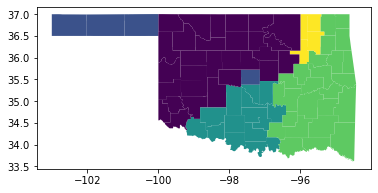

In [13]:
# Which district is each county assigned to?
assignment = [ -1 for u in G.nodes ]
    
# for each district j
for j in range(len(districts)):
    
    # for each node i in this district
    for i in districts[j]:
        
        # What is its GEOID?
        geoID = G.nodes[i]["GEOID10"]
        
        # Need to find this GEOID in the dataframe
        for u in G.nodes:
            if geoID == df['GEOID10'][u]: # Found it
                assignment[u] = j # Node u from the dataframe should be assigned to district j

# Now add the assignments to a column of the dataframe and map it
df['assignment'] = assignment
my_fig = df.plot(column='assignment').get_figure()